## Speckle generation example

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from mmfsim.grid import Grid
from mmfsim.fiber import GrinFiber, StepIndexFiber
from mmfsim.speckle import DegenGrinSpeckle, DegenStepIndexSpeckle
from mmfsim.transforms import fourier_transform, fresnel_transform

In [2]:
from waveoptics.plots.plots import complex_to_hsv

def get_kspace_extent(grid, pad):
    dNxy = 1/((pad+1) * grid.extents) # Size of a sample in the Fourier plane [1/m]
    limNxy = ((pad+1) * grid.pixel_numbers[0] / 2) * dNxy ; # Interval boundaries [1/m]
    kx = 2 * np.pi * np.arange(start= -limNxy[0], stop=limNxy[0], step=dNxy[0]) # Angular frequencies vector (x-axis) [rad/m]
    ky = 2 * np.pi * np.arange(start= -limNxy[1], stop=limNxy[1], step=dNxy[1]) # Angular frequencies vector (y-axis) [rad/m]
    return (grid.pixel_numbers * dNxy * 2 * np.pi)

def simple_complex_imshow(complex_array: np.ndarray,
                   rmin: float = None,
                   rmax: float = None,
                   hue_start: int = 0,
                   extent: tuple = None,
                   ):
    ax = plt.gca()
    plt.imshow(complex_to_hsv(complex_array, rmin, rmax, hue_start), extent=extent)
    return ax

In [3]:
fiber_type = 'grin' # 'grin' or 'step'
grid_settings: dict = {'pixel_size': 0.5e-6, 'pixel_numbers': (256, 256)}
fiber_settings: dict = {'radius': 25e-6, 'wavelength': 1064e-9, 'n1': 1.465, 'n2': 1.45}
fourier_settings: dict = {'pad': 2}
fresnel_settings: dict = {'delta_z': 50e-6}

grid = Grid(**grid_settings)
if fiber_type.lower() in ['grin']:
    fiber = GrinFiber(**fiber_settings)
elif fiber_type.lower() in ['step', 'si']:
    fiber = StepIndexFiber(**fiber_settings)
else:
    raise ValueError(f"Unknown fiber type.")
print(fiber)

fiber.compute_modes_fields(grid)

GrinFiber instance with:
  - Radius: 25.0 um
  - Core index: 1.465
  - Cladding index: 1.45
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.209
  - Number of guided LP modes: 59
  - Number of guided LP modes (counting degenerates): 104
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[1.465      0.         0.         1.        ]
 [1.46403317 1.         0.         2.        ]
 [1.46306634 2.         1.         1.        ]
 [1.46306634 2.         0.         3.        ]
 [1.46209952 3.         1.         2.        ]
 [1.46209952 3.         0.         4.        ]
 [1.46113269 4.         2.         1.        ]
 [1.46113269 4.         1.         3.        ]
 [1.46113269 4.         0.         5.        ]
 [1.46016586 5.         2.         2.        ]]


In [17]:
from copy import deepcopy

if fiber_type.lower() in ['grin']:
    speckle = DegenGrinSpeckle(fiber, grid, N_modes=fiber._N_modes_degen)
elif fiber_type.lower() in ['step', 'si']:
    speckle = DegenStepIndexSpeckle(fiber, grid, N_modes=fiber._N_modes_degen)
else:
    raise ValueError(f"Unknown fiber type.")
speckle.compose()

fourier_field = fourier_transform(speckle.field, **fourier_settings)
speckle_fourier = deepcopy(speckle)
speckle_fourier.field = fourier_field

fresnel_field = fresnel_transform(speckle.field, grid=grid, **fresnel_settings, **fourier_settings)
speckle_fresnel = deepcopy(speckle)
speckle_fresnel.field = fresnel_field

In [17]:
def add_custom_colorbar_to_axes(colorbar_image: np.ndarray, ax, fig):
    cbar_ax = fig.add_axes([ax.get_position().x1+0.01,
                                ax.get_position().y0,
                                0.03,
                                ax.get_position().height])
    cbar_ax.imshow(colorbar_image, aspect=15)
    cbar_ax.set_xticks([0, 99], labels=['0', '1'], fontsize=10)
    cbar_ax.set_yticks([0, 50, 99], labels=[r'$+\pi$', '0', r'$-\pi$'], fontsize=10)
    cbar_ax.xaxis.set_ticks_position('bottom')
    cbar_ax.yaxis.set_ticks_position('right')

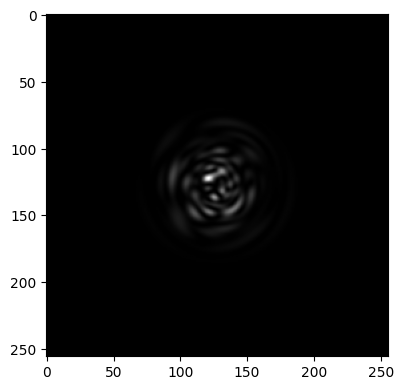

In [18]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.imshow(np.square(np.abs(speckle.field)), cmap='gray')

(256, 256, 118)
(256, 256, 118)
(118, 156, 156)


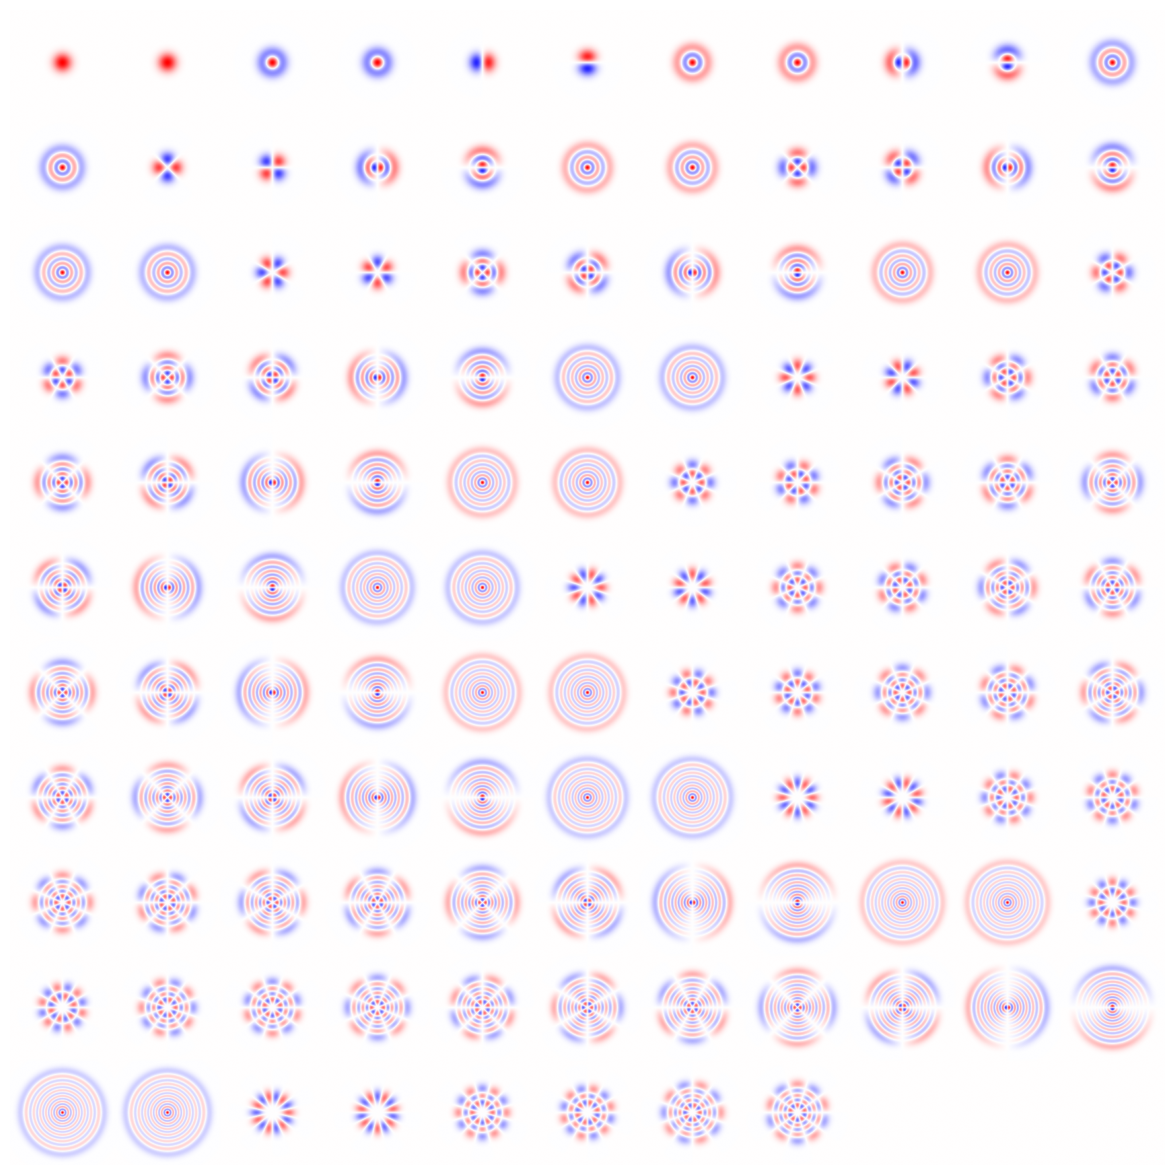

In [46]:
from hcmmf.utils import tile_matrix

modes = np.copy(fiber._modes)

modes = np.transpose(modes, (0, 1, 3, 2))  # now shape is (256, 256, 59, 2)
modes = modes.reshape(256, 256, 59*2)      # now shape is (256, 256, 118)

print(modes.shape)

modes = np.reshape(modes, (modes.shape[0], modes.shape[1], np.prod(modes.shape[2:])))
print(modes.shape)

modes = np.moveaxis(modes, 2, 0)

win = 50
modes = modes[:, win:-win, win:-win]
print(modes.shape)


tiled_modes = tile_matrix(modes, complex=False)

plt.figure(figsize=(15, 15))
plt.imshow(tiled_modes, cmap='bwr', vmin=-np.max(np.abs(tiled_modes)), vmax=np.max(np.abs(tiled_modes)))
plt.axis('off')

plt.savefig('modes_grin.png', dpi=300)
plt.savefig('modes_grin.svg')

Text(0.5, 1.0, 'Fourier transform')

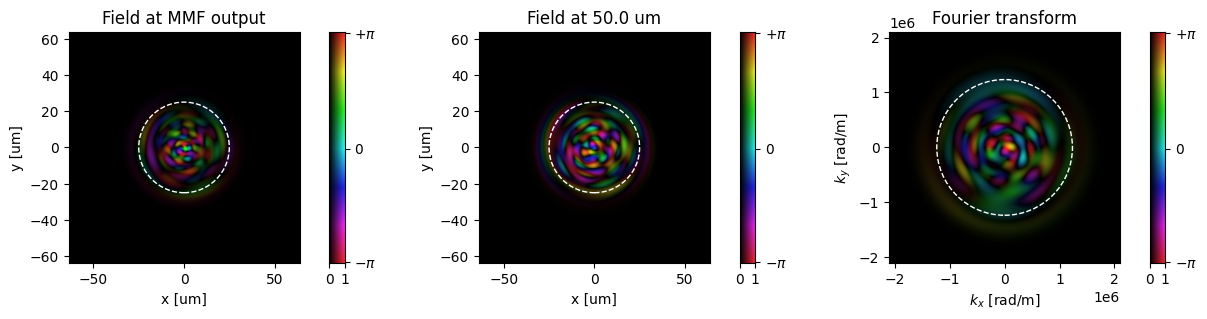

In [18]:
from waveoptics.plots.plots import complex_colormap

spatial_extent = np.array([np.min(grid.x), np.max(grid.x), np.min(grid.y), np.max(grid.y)]) * 1e6
k_extents = get_kspace_extent(grid, **fourier_settings)
kspace_extent = np.array([-k_extents[0] / 2, +k_extents[0] / 2, -k_extents[1] / 2, +k_extents[1] / 2])


core_um = fiber.radius * 1e6
core_k_na = 2 * np.pi * fiber._NA / fiber.wavelength

circle_core = plt.Circle((-grid.offsets[0], -grid.offsets[1]), core_um, fill=False, edgecolor='w', linestyle='--')
circle_core_fresnel = plt.Circle((-grid.offsets[0], -grid.offsets[1]), core_um, fill=False, edgecolor='w', linestyle='--')
circle_core_fourier = plt.Circle((-grid.offsets[0], -grid.offsets[1]), core_k_na, fill=False, edgecolor='w', linestyle='--')

cbar_img = complex_colormap()


cbar_img = complex_colormap()



fig = plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
ax = simple_complex_imshow(speckle.field, extent=spatial_extent)
add_custom_colorbar_to_axes(cbar_img, ax=ax, fig=fig)
ax.add_patch(circle_core)
ax.set_xlabel("x [um]")
ax.set_ylabel("y [um]")
ax.set_title("Field at MMF output")

plt.subplot(1, 3, 2)
ax = simple_complex_imshow(speckle_fresnel.field, extent=spatial_extent)
add_custom_colorbar_to_axes(cbar_img, ax=ax, fig=fig)
ax.add_patch(circle_core_fresnel)
ax.set_xlabel("x [um]")
ax.set_ylabel("y [um]")
ax.set_title(f"Field at {fresnel_settings['delta_z'] * 1e6} um")


plt.subplot(1, 3, 3)
ax = simple_complex_imshow(speckle_fourier.field, extent=kspace_extent)
add_custom_colorbar_to_axes(cbar_img, ax=ax, fig=fig)
ax.add_patch(circle_core_fourier)
ax.set_xlabel(r"$k_x$" + " [rad/m]")
ax.set_ylabel(r"$k_y$" + " [rad/m]")
ax.set_title("Fourier transform")

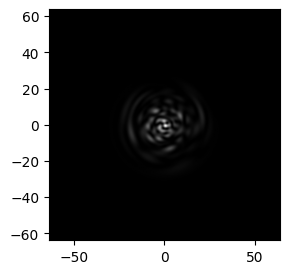

In [23]:

fig = plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.imshow(np.square(np.abs(speckle.field)), extent=spatial_extent, cmap='gray')
# add_custom_colorbar_to_axes(cbar_img, ax=ax, fig=fig)
# ax.add_patch(circle_core)
# ax.set_xlabel("x [um]")
# ax.set_ylabel("y [um]")
# ax.set_title("Field at MMF output")

# plt.subplot(1, 3, 2)
# ax = simple_complex_imshow(speckle_fresnel.field, extent=spatial_extent)
# add_custom_colorbar_to_axes(cbar_img, ax=ax, fig=fig)
# ax.add_patch(circle_core_fresnel)
# ax.set_xlabel("x [um]")
# ax.set_ylabel("y [um]")
# ax.set_title(f"Field at {fresnel_settings['delta_z'] * 1e6} um")


# plt.subplot(1, 3, 3)
# ax = simple_complex_imshow(speckle_fourier.field, extent=kspace_extent)
# add_custom_colorbar_to_axes(cbar_img, ax=ax, fig=fig)
# ax.add_patch(circle_core_fourier)
# ax.set_xlabel(r"$k_x$" + " [rad/m]")
# ax.set_ylabel(r"$k_y$" + " [rad/m]")
# ax.set_title("Fourier transform")